In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [14]:
from datetime import datetime

import numpy as np
import tensorflow as tf

import layers
import losses
from data import caltech_101
from utils import batch, norm

In [15]:
np.random.seed(42)
tf.set_random_seed(42)

In [16]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = caltech_101.load_data(force=True)

Extracting... Done!


In [17]:
IMG_SIZE = 64

In [18]:
X_max = X_train.max()
X_min = X_train.min()

X_train = (X_train - X_min)/(X_max - X_min)
X_val = (X_val - X_min)/(X_max - X_min)
X_test = (X_test - X_min)/(X_max - X_min)

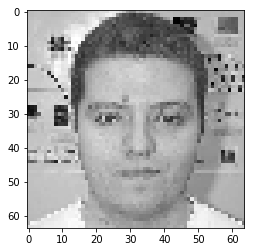

In [19]:
plt.imshow(X_test[0].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")

In [20]:
print(y_train[1])

1.0


In [21]:
# TensorBoard logging
ROOT_LOGDIR = "face_capsnet_logs"

def log_run():
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}".format(ROOT_LOGDIR, now)
    
    return logdir

## Model

In [26]:
tf.reset_default_graph()

X = tf.placeholder(shape=[None, IMG_SIZE, IMG_SIZE, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
y_one_hot = tf.one_hot(y, depth=2, name="y_one_hot")


conv1 = tf.layers.conv2d(
    X,
    filters=256,
    kernel_size=9,
    strides=1,
    padding="valid",
    name="conv1"
)


primaryCaps = layers.primaryCaps(
    conv1,
    caps=32,
    dims = 8,
    kernel_size= 9,
    strides= 2,
    name="primaryCaps"
)

outputCaps = layers.denseCaps(
    primaryCaps,
    caps=2,
    dims=16
)

probabilities = norm(outputCaps, axis=-1, name="probabilities")
loss = losses.margin_loss(y_one_hot, probabilities, name="loss")

predictions = tf.argmax(probabilities, axis=-1, name="predictions")
with tf.variable_scope("accuracy"):
    correct = tf.equal(y, predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

train_loss_summary = tf.summary.scalar("train_loss", loss)
train_accuracy_summary = tf.summary.scalar("train_accuracy", accuracy)
train_summaries = tf.summary.merge([train_loss_summary, train_accuracy_summary])

validation_loss_summary = tf.summary.scalar("validation_loss", loss)
validation_accuracy_summary = tf.summary.scalar("validation_accuracy", accuracy)
validation_summaries = tf.summary.merge([validation_loss_summary, validation_accuracy_summary])

test_loss_summary = tf.summary.scalar("test_loss", loss)
test_accuracy_summary = tf.summary.scalar("test_accuracy", accuracy)
test_summaries = tf.summary.merge([test_loss_summary, test_accuracy_summary])

In [27]:
logdir = log_run()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

optimizer = tf.train.AdamOptimizer(1e-4)

# TODO gradients?
training_op = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

num_epochs = 2
batch_size = 12
checkpoint_path = './capsnet_face_save'

train_iterations_per_epoch = len(X_train) // batch_size
validation_iterations_per_epoch = len(X_val) // batch_size

best_validation_loss = np.infty

with tf.Session() as sess:
    init.run()
    
    for epoch in range(num_epochs):        
        print('[Epoch {}/{}]'.format(epoch + 1, num_epochs))
        
        # TRAIN
        train_losses = []
        train_accuracies = []
        
        for iteration, (X_batch, y_batch) in enumerate(batch(X_train, y_train, batch_size=batch_size)):
        
            training_op.run(
                feed_dict={
                    X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                    y: y_batch.reshape([-1])
                }
            )
            
            train_loss, train_accuracy = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                    y: y_batch.reshape([-1])
                }
            )
        
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            if (iteration + 1) % 10 == 0:
                print('\rTrain | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
                    iteration + 1,
                    train_iterations_per_epoch,
                    (iteration + 1) * 100 /train_iterations_per_epoch,
                    train_accuracy * 100,
                    train_loss
                ), 
                end="")
                
                train_summary_str = train_summaries.eval(
                    feed_dict={
                        X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                        y: y_batch.reshape([-1])
                    }
                )
                
                file_writer.add_summary(train_summary_str, epoch*train_iterations_per_epoch + iteration)
            
        avg_train_loss = np.mean(train_losses)
        avg_train_accuracy = np.mean(train_accuracies)
        
        print('\rTrain | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
            avg_train_accuracy * 100,
            avg_train_loss), 
        end=" " * 30 + "\n")
        
        
        # VALIDATE
        validation_losses = []
        validation_accuracies = []
        
        for iteration, (X_batch, y_batch) in enumerate(batch(X_val, y_val, batch_size=batch_size)):
            
            validation_loss, validation_accuracy = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                    y: y_batch.reshape([-1])
                }
            )
            
            validation_losses.append(validation_loss)
            validation_accuracies.append(validation_accuracy)
            
            if (iteration + 1) % 5 == 0:
                print('\rValidation | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
                    iteration + 1,
                    validation_iterations_per_epoch,
                    (iteration + 1) * 100 / validation_iterations_per_epoch,
                    validation_accuracy * 100,
                    validation_loss
                ), 
                end="")
                
                validation_summary_str = validation_summaries.eval(
                    feed_dict={
                        X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                        y: y_batch.reshape([-1])
                    }
                )
                
                file_writer.add_summary(validation_summary_str, epoch*validation_iterations_per_epoch + iteration)
            
        avg_validation_loss = np.mean(validation_losses)
        avg_validation_accuracy = np.mean(validation_accuracies)
        
        print('\rValidation | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
            avg_validation_accuracy * 100,
            avg_validation_loss), 
        end=" " * 30 + "\n")
        
        if avg_validation_loss < best_validation_loss:
            saver.save(sess, checkpoint_path)
            best_validation_loss = avg_validation_loss

[Epoch 1/2]
Train | Average Accuracy: 91.7582% Loss: 0.094137                              
Validation | Average Accuracy: 100.0000% Loss: 0.030041                              
[Epoch 2/2]
Train | Average Accuracy: 99.2674% Loss: 0.021378                              
Validation | Average Accuracy: 100.0000% Loss: 0.015153                              


In [65]:
# TEST

test_iterations = len(X_test) // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    test_losses = []
    test_accuracies = []
    
    for iteration, (X_batch, y_batch) in enumerate(batch(X_test, y_test, batch_size)):
        print(X_batch.shape, y_batch.shape)
        
        test_loss, test_accuracy = sess.run(
            [loss, accuracy],
            feed_dict={
                X: X_batch.reshape([-1, IMG_SIZE, IMG_SIZE, 1]),
                y: y_batch.reshape([-1])
            }
        )
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print("\rEvaluation | Iteration {}/{} ({:.1f}%)".format(
            iteration + 1, 
            test_iterations, 
            (iteration + 1) * 100/test_iterations),
             end=" " * 30
        )
        
    avg_test_loss = np.mean(test_losses)
    avg_test_accuracy = np.mean(test_accuracies)
    
    print("\rEvaluation | Accuracy: {:.4f}% Loss: {:.6f}".format(avg_test_accuracy * 100, avg_test_loss))

INFO:tensorflow:Restoring parameters from ./capsnet_face_save
(12, 4096) (12,)
Evaluation | Iteration 1/8 (12.5%)                              (12, 4096) (12,)
Evaluation | Iteration 2/8 (25.0%)                              (12, 4096) (12,)
Evaluation | Iteration 3/8 (37.5%)                              (12, 4096) (12,)
Evaluation | Iteration 4/8 (50.0%)                              (12, 4096) (12,)
Evaluation | Iteration 5/8 (62.5%)                              (12, 4096) (12,)
Evaluation | Iteration 6/8 (75.0%)                              (12, 4096) (12,)
Evaluation | Iteration 7/8 (87.5%)                              (12, 4096) (12,)
Evaluation | Iteration 8/8 (100.0%)                              (4, 4096) (4,)
Evaluation | Accuracy: 98.1482% Loss: 0.024869                   
